In [1]:
import pandas as pd
import geopandas as gpd
import sqlalchemy
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
import mapclassify
from pysal.viz import splot
from splot.esda import plot_moran
from splot import esda as esdaplot
from pysal.explore import esda
from pysal.lib import weights

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/spaghetti/network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Create a SQLAlchemy engine
conn_string = 'postgresql://lizavabistsevits:@localhost:5432/taiwan' # database connection string
engine = create_engine(conn_string)

# Insert dengue cases into geodataframe
tw = gpd.read_postgis(
    'SELECT * FROM dengue_total_2012_2024_all_geom',
    engine,
    geom_col='geom'
)

tw.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   code            349 non-null    int64   
 1   name            349 non-null    object  
 2   county          349 non-null    int64   
 3   total_pop       349 non-null    int64   
 4   case_count      349 non-null    int64   
 5   dengue_per_10k  349 non-null    float64 
 6   geom            349 non-null    geometry
dtypes: float64(1), geometry(1), int64(4), object(1)
memory usage: 19.2+ KB


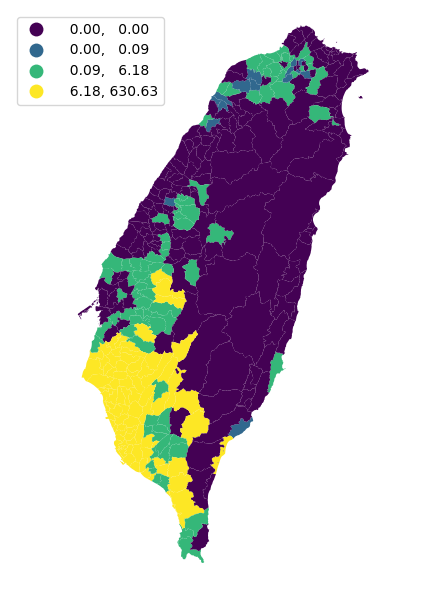

In [3]:
f, ax = plt.subplots(1, figsize=(12, 6))
tw.plot(
    column='dengue_per_10k',
    cmap='viridis',
    scheme='quantiles',
    k=4,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=ax,
)

# Specify plot coordinates
ax.set_xlim(100000, 400000)
ax.set_ylim(2410000, 2810000)

ax.set_axis_off()

plt.tight_layout()

In [4]:
# Custom classification scheme
cutsom_scheme = mapclassify.UserDefined(
    tw['dengue_per_10k'], [0, 1, 10, 50, 631]
)
cutsom_scheme

UserDefined

    Interval       Count
------------------------
[  0.00,   0.00] |   160
(  0.00,   1.00] |    63
(  1.00,  10.00] |    53
( 10.00,  50.00] |    39
( 50.00, 631.00] |    34

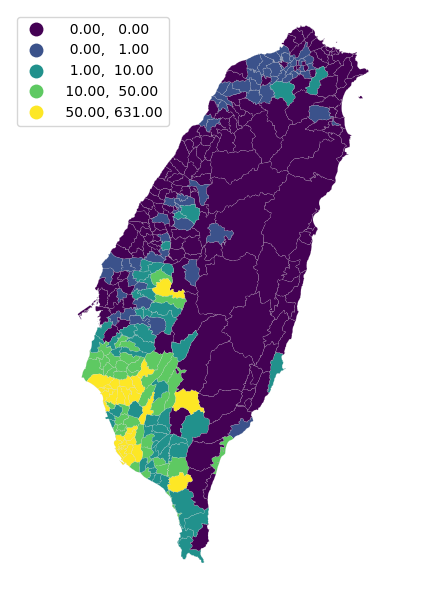

In [5]:
f, ax = plt.subplots(1, figsize=(12, 6))
cutsom_scheme.plot(
    tw, 
    legend=True,
    legend_kwds={'loc': 'upper left'}, 
    cmap='viridis',
    ax=ax,
)

# Specify plot coordinates
ax.set_xlim(100000, 400000)
ax.set_ylim(2410000, 2810000)

ax.set_axis_off()

plt.tight_layout()

In [6]:
# Generate spatial weights (k-nearest neigbor)
w = weights.KNN.from_dataframe(tw, k=8)

# Row-standardization
w.transform = 'R'

#### Moran's I

In [7]:
# Strandardise by subtracting mean
tw['dengue_per_10k_std'] = tw['dengue_per_10k'] - tw['dengue_per_10k'].mean()

# Calculate spatial lag of standardised variable
tw['dengue_per_10k_lag_std'] = weights.lag_spatial(w, tw['dengue_per_10k_std'])

Text(0.5, 1.0, 'Moran Plot (dengue cases per 10,000 people)')

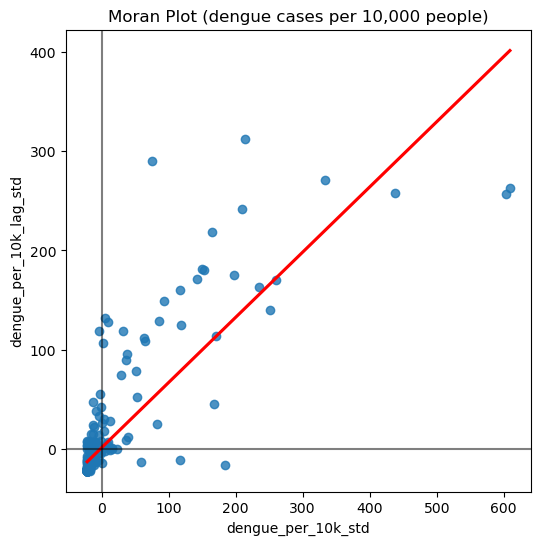

In [8]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='dengue_per_10k_std',
    y='dengue_per_10k_lag_std',
    ci=None,
    data=tw,
    line_kws={'color': 'r'},
)

# Add 0 axis lines
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title("Moran Plot (dengue cases per 10,000 people)")

In [9]:
# Calculate Moran's I
moran = esda.moran.Moran(tw['dengue_per_10k'], w)

print(f"Moran's I: {moran.I}")
print(f"Pseudo p-value: {moran.p_sim}")

Moran's I: 0.6557544180027932
Pseudo p-value: 0.001


(<Figure size 1000x400 with 2 Axes>,
 array([<Axes: title={'center': 'Reference Distribution'}, xlabel='Moran I: 0.66', ylabel='Density'>,
        <Axes: title={'center': 'Moran Scatterplot (0.66)'}, xlabel='Attribute', ylabel='Spatial Lag'>],
       dtype=object))

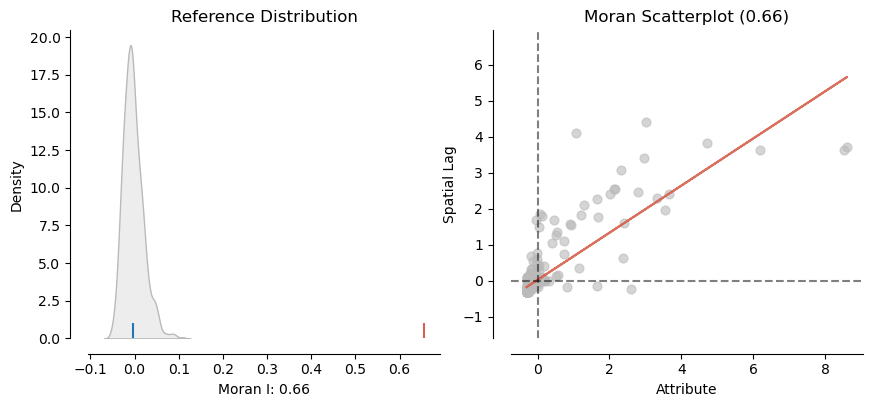

In [10]:
plot_moran(moran)

#### Geary's C

In [11]:
# Calculate Geary's C
geary = esda.geary.Geary(tw['dengue_per_10k'], w)

print(f"Geary's C: {geary.C}")
print(f"Pseudo p-value: {geary.p_sim}")

Geary's C: 0.38116027551197246
Pseudo p-value: 0.001


#### Getis and Ord's G

In [12]:
# Calculate minimum threshold distance to ensure every observation has at least one neighbour
pts = tw.centroid
xys = pd.DataFrame({'X': pts.x, 'Y': pts.y})
min_thr = weights.util.min_threshold_distance(xys)

print(f"Minimum threshold distance: {min_thr} meters")

Minimum threshold distance: 81235.69428160728 meters


In [13]:
# Calculate Getis and Ord's G using minimum threshold distance
w_tw = weights.DistanceBand.from_dataframe(tw, min_thr)
gao = esda.getisord.G(tw['dengue_per_10k'], w_tw)

print(f"Getis and Ord's G: {gao.G}")
print(f"Pseudo p-value: {gao.p_sim}")

Getis and Ord's G: 0.895445736095029
Pseudo p-value: 0.001


#### Local Moran's I

Text(-40, -35, 'LL')

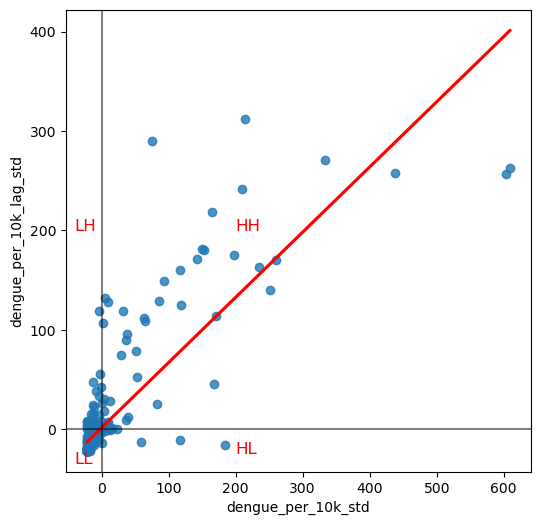

In [14]:
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(
    x='dengue_per_10k_std',
    y='dengue_per_10k_lag_std',
    ci=None,
    data=tw,
    line_kws={'color': 'r'},
)

# Add 0 axis lines
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)

# Add text labels for each quadrant
plt.text(200, 200, 'HH', fontsize=12, c='r') # high-high
plt.text(200, -25, 'HL', fontsize=12, c='r') # high-low
plt.text(-40, 200.0, 'LH', fontsize=12, c='r') # low-high
plt.text(-40, -35, 'LL', fontsize=12, c='r') # low-low

In [15]:
# Calculate local Moran's I
lisa = esda.moran.Moran_Local(tw['dengue_per_10k'], w)

<Axes: ylabel='Density'>

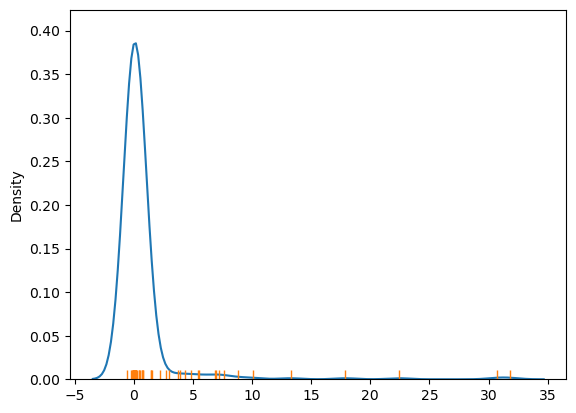

In [16]:
# Plot kernel density estimation
ax = sns.kdeplot(lisa.Is)

# Add one small bar for each observation
sns.rugplot(lisa.Is, ax=ax)

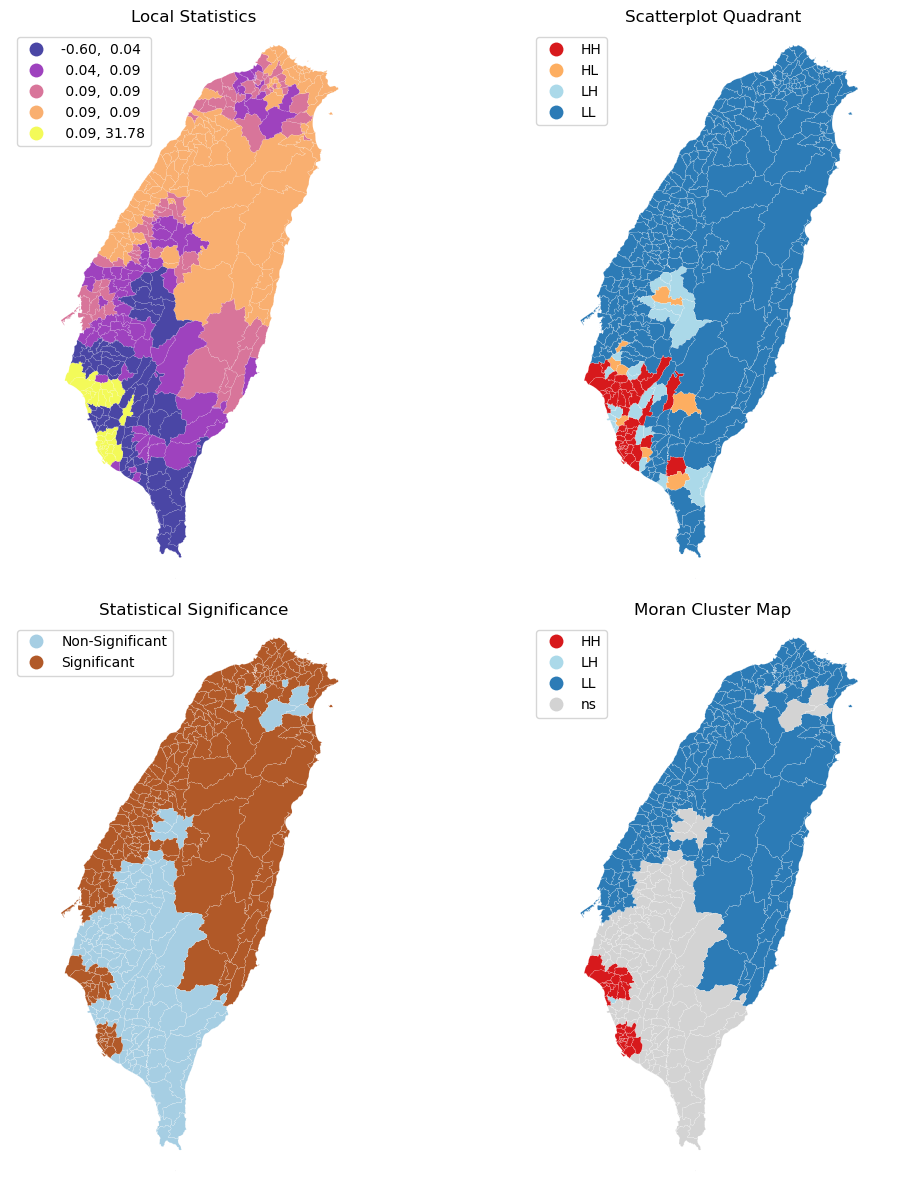

In [23]:
f, axs = plt.subplots(2, 2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 – Local statistics
tw.assign(Is=lisa.Is).plot( # Assign new column with local statistics
    column='Is',
    cmap='plasma',
    scheme='quantiles',
    k=5,
    edgecolor='white',
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=axs[0])

# Subplot 2 – Quadrant categories
# Use p-value=1 to assign quadrant (from Moran plot) to all observations
esdaplot.lisa_cluster(lisa, tw, p=1, legend_kwds={'loc': 'upper left'}, ax=axs[1])

# Subplot 3 – Significance map
# Find out significant observations (assign 1 if significant, 0 otherwise)
labels = pd.Series(
    1 * (lisa.p_sim < 0.05), index=tw.index).map({1: 'Significant', 0: 'Non-Significant'}) # Rename 1 to "Significant and 0 to "Non-significant"

tw.assign(cl=labels).plot(
    column='cl',
    categorical=True,
    k=2,
    cmap='Paired',
    linewidth=0.1,
    edgecolor='white',
    legend=True,
    legend_kwds={'loc': 'upper left'},
    ax=axs[2])

# Subplot 4 – Cluster map
# Use p-value=0.05 to select statistically significant clusters
esdaplot.lisa_cluster(lisa, tw, p=0.05, legend_kwds={'loc': 'upper left'}, ax=axs[3])

# Add titles and specify coordinates
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            'Local Statistics',
            'Scatterplot Quadrant',
            'Statistical Significance',
            'Moran Cluster Map',
        ][i])
    ax.set_xlim(110000, 380000)
    ax.set_ylim(2400000, 2810000)

plt.tight_layout()

In [18]:
# Find out how many townships are in each quadrant
# 1: HH 2: LH 3: LL 4: HL
counts = pd.value_counts(lisa.q)
counts

/var/folders/xj/422_hdhn1bz0x9_khxxv4d100000gn/T/ipykernel_48484/4118522615.py:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pd.value_counts(lisa.q)


3    272
1     44
2     25
4      8
Name: count, dtype: int64

In [19]:
pct_signif = (lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)
print(f"{round(pct_signif)}% of townships are clustered.")

64% of townships are clustered.


#### Getis and Ord’s local statistics

In [20]:
# Calculate Gi
go_gi = esda.getisord.G_Local(tw['dengue_per_10k'], w)

# Calculate Gi*
go_gi_star = esda.getisord.G_Local(tw['dengue_per_10k'], w, star=True)

/opt/homebrew/anaconda3/envs/dengue-data-exploration/lib/python3.11/site-packages/esda/getisord.py:421: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  w, star = _infer_star_and_structure_w(w, star, transform)


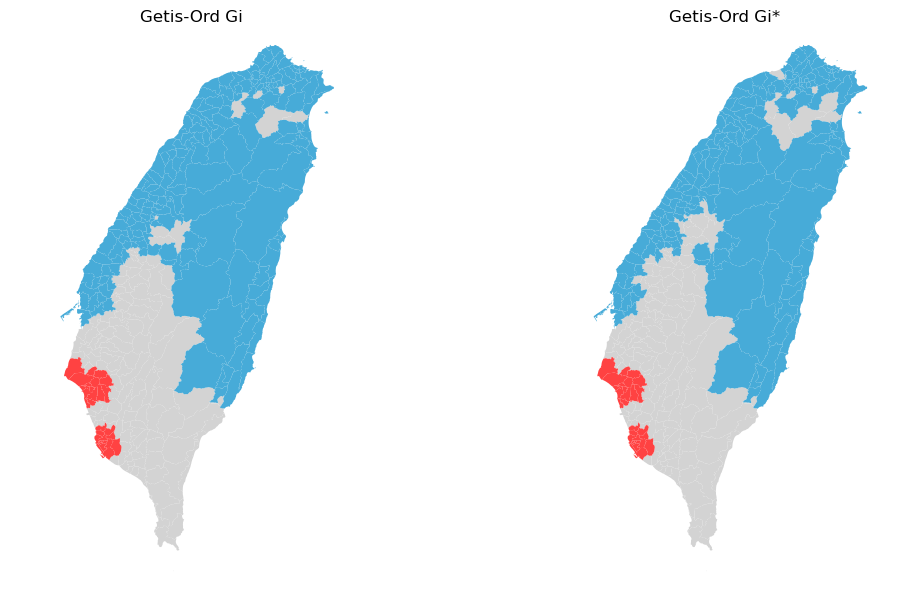

In [24]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.flatten()

# Plot 1 – Getis-Ord Gi
# Find significant observations
signif = go_gi.p_sim < 0.05
# Plot non-significant clusters
ns = tw.loc[signif == False, 'geom']
ns.plot(color='lightgrey', ax=axs[0])
# Plot hotspots 
hs = tw.loc[(go_gi.Zs > 0) & (signif == True), 'geom']
hs.plot(color='#ff4242', ax=axs[0])
# Plot coldspots
cs = tw.loc[(go_gi.Zs < 0) & (signif == True), 'geom']
cs.plot(color='#47abd8', ax=axs[0])

# Plot 2 – Getis-Ord Gi*
# Find significant observations
signif = go_gi_star.p_sim < 0.05
# Plot non-significant clusters
ns = tw.loc[signif == False, 'geom']
ns.plot(color='lightgrey', ax=axs[1])
# Plot hotspots 
hs = tw.loc[(go_gi_star.Zs > 0) & (signif == True), 'geom']
hs.plot(color='#ff4242', ax=axs[1])
# Plot coldspots
cs = tw.loc[(go_gi_star.Zs < 0) & (signif == True), 'geom']
cs.plot(color='#47abd8', ax=axs[1])

# Add titles and specify coordinates
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(['Getis-Ord Gi', 'Getis-Ord Gi*'][i])
    ax.set_xlim(110000, 380000)
    ax.set_ylim(2400000, 2810000)

plt.tight_layout()